In [1]:
import tensorflow as tf
import numpy as np

# Read in

In [2]:
num_classes = 24
def parse_example(filename_queue):
    # Define how to parse the example
    
    reader = tf.TFRecordReader()
    _, example = reader.read(filename_queue)
    
    context_features = {
        'length': tf.FixedLenFeature([1], dtype=tf.int64),
        'labels': tf.FixedLenFeature([24], dtype=tf.int64)
    }
    sequence_features = {
        "tokens": tf.FixedLenSequenceFeature([], dtype=tf.int64)
    }
    context_parsed, sequence_parsed = tf.parse_single_sequence_example(
        serialized=example,
        context_features=context_features,
        sequence_features=sequence_features
    )
    return context_parsed, sequence_parsed

In [3]:
filename_queue = tf.train.string_input_producer(['data/cnn.TFRecord'])
context_parsed, sequence_parsed = parse_example(filename_queue)
batch_size = 16

x = tf.train.batch(
        tensors=sequence_parsed,
        batch_size=batch_size,
        dynamic_pad=True)['tokens']


y = tf.train.batch(
    tensors=context_parsed,
    batch_size=batch_size)['labels']

x = tf.cast(x, tf.int32)
y = tf.cast(y, tf.float32)

In [4]:
vocab = tf.contrib.learn.preprocessing.VocabularyProcessor.restore(
    'data/context.vocab')
max_doc_len = vocab.max_document_length
vocabulary_size = len(vocab.vocabulary_)

# Word Embedding

<img src='./img/word-emb.png'>

In [5]:

embedding_size = 128
# BatchSize, SeqLen
#x = tf.placeholder(tf.int64, [batch_size, None])
with tf.device('/cpu'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, x)
    # BatchSize, SeqLen, EmbeddSize, Channels
    embed = tf.reshape(embed, [batch_size, -1, embedding_size, 1])


In [6]:
embed

<tf.Tensor 'Reshape:0' shape=(16, ?, 128, 1) dtype=float32>

# Convolution

<img src='./img/conv.png'>

In [7]:
# kernel is wide as each word embedding representation
# kernel height defines how much word will it take into account
kernel_heights = [3, 4, 5, 6, 7]
num_filters = 40

k_max = 1
max_pooled = []

for height in kernel_heights:
    conv = tf.contrib.layers.convolution2d(
         embed, num_filters, [height, embedding_size], padding='VALID')
    
    # BatchSize, ConvolvedWordTuples, SingleWordWindow(=1), ConvFeatures
    conv_tr = tf.transpose(conv, perm=[0, 3, 2, 1])
    pool = tf.nn.top_k(conv_tr, k=k_max, sorted=False).values
    max_pooled.append(pool)

feature = tf.concat(3, max_pooled)
feature = tf.transpose(feature, [0, 3, 1, 2])    

## Fix Dimensions

**`feauture`** has the following dimensions **`[batch_size, len(kernel_heights), num_filters, k_max]`**

Which means each *variable* length sequence sample is parsed by a convolution kernel taking in account **`kernel_height`** number of neighbouring *embedded word vectors* with size **`embedding_size`**.

Since this representation is still variable length `seq_len - kernel_height + 1`, use k_max pooling, to obtain fixed dimensional representations for classifying layers.

# Classification

In [9]:
#num_of_classes = genres.get_shape().to_list()[1]
hidden_sizes = [400, 300, 200, 100]
keep_prob = tf.placeholder_with_default(0.5, [])

h = tf.contrib.layers.flatten(feature)
for width in hidden_sizes:
    h = tf.contrib.layers.fully_connected(h, width)
    h = tf.nn.dropout(h, keep_prob)

# logits for cross-entropy
logit = tf.contrib.layers.fully_connected(
    h, num_classes, activation_fn=None)    
y_pred = tf.sigmoid(logit)
tf.train.SummaryWriter

tensorflow.python.training.summary_io.SummaryWriter

# Training

In [10]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, targets=y)
loss = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer().minimize(loss)

In [11]:
train_steps = 2000
sess = tf.InteractiveSession()

coord = tf.train.Coordinator()
sess.run(tf.global_variables_initializer())
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

saver = tf.train.Saver()

try:
    counter = 0
    while counter < train_steps and not coord.should_stop():
        opt.run()
        counter += 1

except tf.errors.OutOfRangeError:
    pass
finally:
    # When done, ask the threads to stop.
    print('Done training')
    coord.request_stop()

save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)    
    
coord.join(threads)
#sess.close()

Done training
Model saved in file: /tmp/model.ckpt


# Evaluation

In [13]:
tf.get_default_session()

In [17]:
total = batch_size * num_classes
missed = tf.reduce_sum(tf.abs(y - tf.round(y_pred) ) )
e = (total - missed) / total

saver = tf.train.Saver()

accuracy = 0

eval_steps = 10
sess = tf.InteractiveSession()
coord = tf.train.Coordinator()
#sess.run(tf.global_variables_initializer())
saver.restore(sess, '/tmp/model.ckpt')
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

try:
    counter = 0
    while counter < eval_steps and not coord.should_stop():
        accuracy += e.eval({keep_prob:1.0})
        counter += 1

except tf.errors.OutOfRangeError:
    pass
finally:
    # When done, ask the threads to stop.
    print('Done evaluating, overall accuracy:', accuracy/eval_steps)
    coord.request_stop()

coord.join(threads)
#sess.close()

Done evaluating, overall accuracy: 0.895833343267


In [24]:

solution = tf.placeholder(tf.float32)
prediction = tf.placeholder(tf.float32)

e = 1-tf.reduce_mean(tf.abs(solution-tf.round(prediction)))


with tf.Session() as sess:
    print(e.eval({solution:[1.0, 0.0, 0.0], prediction:[.6, .4, .51]}))
    print(e.eval({solution:[1.0, 0.0, 0.0], prediction:[.6, .4, .5]}))

0.666667
1.0


# Miscellaneous

In [12]:
tf.app.flags.FLAGS

In [40]:
losses = [0]
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        while not coord.should_stop():
            losses.append(loss.eval())
            opt.run()
            it = len(losses)
            if it%100 == 0:
                print(it, losses[-1])
    
    #except tf.errors.InvalidArgumentError:
        #print('helo')
        #pass
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
    
    coord.request_stop()
    coord.join(threads)
    sess.close()

100 0.25076
200 0.267292
300 0.512336
400 0.293677
500 0.36872
600 0.267313
700 0.208635
800 0.249259
900 0.349146
1000 0.222504
1100 0.198693
1200 0.245067
1300 0.313513
1400 0.343715
1500 0.140426
1600 0.270642
1700 0.332704
1800 0.410537
1900 0.289152
2000 0.196568
2100 0.333482
2200 0.235951
2300 0.313237
2400 0.175797
2500 0.150299
2600 0.424631
2700 0.253511
2800 0.212224
2900 0.162862
3000 0.437853
3100 0.389305
3200 0.197056
3300 0.115128
3400 0.169339
3500 0.154783
3600 0.313196
3700 0.454853
3800 0.238119
3900 0.261638
4000 0.2801
4100 0.358467
4200 0.342729
4300 0.541408
4400 0.170197
4500 0.20582
4600 0.231597
4700 0.322701
4800 0.146487
4900 0.262212
5000 0.149369
5100 0.354797
5200 0.260069
5300 0.346933
5400 0.31564
5500 0.202566
5600 0.103525
5700 0.306517
5800 0.338604
5900 0.34135


KeyboardInterrupt: 

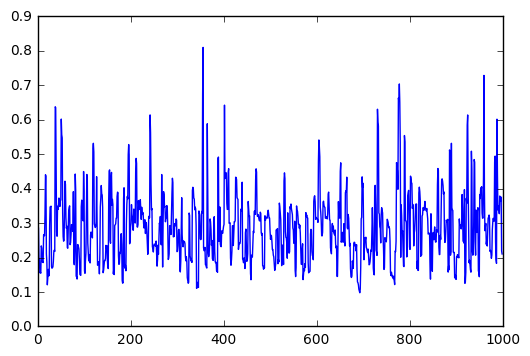

In [41]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(losses[-1000:])

In [13]:
np.array(s) == 24

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [9]:
losses = [0]
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        while not coord.should_stop():
            losses.append(loss.eval())
            opt.run()
            it = len(losses)
            #if it%100 == 0:
            print(it, losses[-1])
    
    except InvalidArgumentError:
        print(res['labels'])
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
    
    coord.request_stop()
    coord.join(threads)
    sess.close()

2 0.726046
3 0.703721
4 0.678497
5 0.691444
6 0.682006
7 0.678877
8 0.664521
9 0.673805
10 0.635797
11 0.66609
12 0.660778
13 0.584394
14 0.602153
15 0.603301
16 0.660363
17 0.650519
18 0.632632
19 0.633452
20 0.640794
21 0.641171
22 0.634815
23 0.59656
24 0.578312
25 0.569958
26 0.55798
27 0.575415
28 0.575234
29 0.578645
30 0.544222
31 0.54977
32 0.537606
33 0.561043
34 0.587754
35 0.586144
36 0.592166
37 0.542048
38 0.550243
39 0.546341
40 0.550679
41 0.5706
42 0.546233
43 0.469282
44 0.480906
45 0.443506
46 0.513069
47 0.522741
48 0.519976
49 0.49802
50 0.453771
51 0.470353
52 0.466071
53 0.446098
54 0.450546
55 0.458696
56 0.547884
57 0.552921
58 0.534752
59 0.497102
60 0.485377
61 0.471382
62 0.438419
63 0.448802
64 0.474656
65 0.46412
66 0.429854
67 0.436704
68 0.41197
69 0.398251
70 0.432087
71 0.420763
72 0.421764
73 0.460211
74 0.404439
75 0.401451
76 0.386375
77 0.466338
78 0.461325
79 0.366651
80 0.371888
81 0.346862
82 0.379104
83 0.406352
84 0.378088
85 0.389207
86 0.3499

NameError: name 'InvalidArgumentError' is not defined

array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [ ]:
with tf.Session() as sess:
    
    batched_data = tf.train.batch(
        tensors=[sequence_parsed['tokens']],
        batch_size=64,
        dynamic_pad=True
    )
    
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    

    #res = sess.run(sequence_parsed['tokens'])
    #res = batched_data.eval()
    res = tf.contrib.learn.run_n({'y':batched_data})
    #print(res[0]['y'])
    coord.request_stop()
    coord.join(threads)
    sess.close()

In [34]:
conv_tr, pool

(<tf.Tensor 'transpose_13:0' shape=(32, 7, 1, ?) dtype=float32>,
 <tf.Tensor 'TopKV2_14:0' shape=(32, 7, 1, 1) dtype=float32>)

In [35]:
feature = tf.concat(3, max_pooled)
feature = tf.transpose(feature, [0, 1, 3, 2])
feature

<tf.Tensor 'transpose_14:0' shape=(32, 7, 3, 1) dtype=float32>

In [37]:
with tf.Session() as sess:
    np.random.randint
    tf.global_variables_initializer().run()
    res = sess.run(max_pooled, {x:test_input})

In [36]:
test_input = np.random.randint(0, 9, (batch_size, 25), dtype=int)
test_input.dtype

dtype('int64')

In [38]:
res[2].shape

(32, 7, 1, 1)

In [23]:
import tensorflow as tf
# Create a tensor [0, 1, 2, 3, 4 ,...]
x = tf.range(1, 10, name="x")
x

<tf.Tensor 'x_1:0' shape=(9,) dtype=int32>

In [58]:
batch_size = 8
embedding_size = 6
sequence_length = 25
num_filters = 10
height = 3

x = tf.placeholder(tf.float32, [batch_size, sequence_length, embedding_size, 1])
conv = tf.contrib.layers.convolution2d(x, num_filters, kernel_size=[height, embedding_size], padding='VALID')
conv

<tf.Tensor 'Conv_7/Relu:0' shape=(8, 23, 1, 10) dtype=float32>

In [48]:
#y = [tf.constant(list(range(n))) for n in range(1,10)]


# [0, 1, 2, 3, 4 ,...]
x = [6, 7, 8, 3, 8]

# A queue that outputs 0,1,2,3,...
range_q = tf.train.range_input_producer(limit=5, shuffle=False)
slice_end = range_q.dequeue()

# Slice x to variable length, i.e. [0], [0, 1], [0, 1, 2], ...
y = tf.slice(x, [0], [3], name="y")


#slice_end, y
#tf.contrib.learn.run_n({'s':slice_end})
tf.contrib.learn.run_n({'y':y})

[{'y': array([6, 7, 8], dtype=int32)}]

In [49]:


batched_data = tf.train.batch(
    #tensors=[[1, 1, 1], [2, 2, 2, 2], [3], [4, 4]],
    tensors=[y],
    batch_size=5,
    dynamic_pad=True
)


# Run the graph
# tf.contrib.learn takes care of starting the queues for us
res = tf.contrib.learn.run_n({"y": batched_data}, n=1, feed_dict=None)

# Print the result
# print("Batch shape: {}".format(res[0]["y"].shape))
print(res[0]["y"])

[[6 7 8]
 [6 7 8]
 [6 7 8]
 [6 7 8]
 [6 7 8]]


In [8]:
# operator has multiple fields, values is a tensor
y = tf.nn.top_k(x, k=3, sorted=False).values

with tf.Session():
    tf.global_variables_initializer().run()
    #batched_data.eval()
    #res = embed.eval({x:batched_data.eval()})
    #emb_W = embeddings.eval()
    max_k_pool = y.eval({x:[np.arange(10), np.arange(10)]})

In [74]:
res.shape, emb_W.shape

((3, 128), (8280, 128))

In [72]:
np.all(emb_W[1:4] == res)

True

All in all this is nasty... embedding_lookup is just doing an indexed selection of a row - However MUST USE CPU

In [73]:
max_k_pool

array([[7, 9, 8],
       [7, 9, 8]], dtype=int32)

In [46]:
res.shape

(3, 128)